# Определение перспективного тарифа для телеком-компании

Описание тарифов

Тариф «Смарт»

 - Ежемесячная плата: 550 рублей
 - Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
 - Стоимость услуг сверх тарифного пакета: 
     - минута разговора: 3 рубля
     - сообщение: 3 рубля
     - 1 Гб интернет-трафика: 200 рублей

Тариф «Ультра»

 - Ежемесячная плата: 1950 рублей
 - Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
 - Стоимость услуг сверх тарифного пакета:
      - минута разговора: 1 рубль
      - сообщение: 1 рубль
      - 1 Гб интернет-трафика: 150 рублей
      
      Примечание:
      
- «Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
- Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.

## Изучение данных из файлов

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

In [2]:
users = pd.read_csv('/datasets/users.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
messages = pd.read_csv('/datasets/messages.csv') 
internet = pd.read_csv('/datasets/internet.csv', index_col=0) 
calls = pd.read_csv('/datasets/calls.csv') 

### Вывод users

In [3]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [4]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


Тип данных - в порядке. Только 38 пользователей прекратили пользоваться тарифом. 

Описание данных Таблицы users:

- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tariff — название тарифного плана

In [5]:
users['tariff'].value_counts() # количество пользователей по тарифам для информации

smart    351
ultra    149
Name: tariff, dtype: int64

 ### Вывод tariffs

In [6]:
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [7]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [8]:
tariffs = tariffs.rename(columns= {'tariff_name': 'tariff'})
tariffs['gb_per_month_included'] = (tariffs['mb_per_month_included'] / 1024).astype(int) # переведем мб в гб
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff,gb_per_month_included
0,50,15360,500,550,200,3,3,smart,15
1,1000,30720,3000,1950,150,1,1,ultra,30


Здесь параметры тарифов smart и ultra. Заменила сразу название колонки tariff и перевела мб в гб

 ### Вывод messages

In [9]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [10]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


В данных messages указаны id сообщений пользователей с датой сообщения. 

Всего было 123 036 сообщения за период

### Вывод internet

In [11]:
internet.head()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


In [12]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            149396 non-null  object 
 1   mb_used       149396 non-null  float64
 2   session_date  149396 non-null  object 
 3   user_id       149396 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB


В таблице internet объем мегабайт, потраченного за каждую сессию user_id с датой
- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя

Всего сессий было 149396.

###  Вывод calls

In [13]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [14]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


В таблице calls уникальные звонки user_id с длительностью в минутах.

In [15]:
calls.describe()

,duration,user_id
count,202607.000000,202607.000000
mean,6.755887,1253.940619
std,5.843365,144.722751
min,0.000000,1000.000000
25%,1.300000,1126.000000
50%,6.000000,1260.000000
75%,10.700000,1379.000000
max,38.000000,1499.000000


## Подготовка данных

### Определение количества звонков и израсходованных минут разговора по месяцам

Каждый звонок округляется отдельно до минуты. Добавим колонку в минутах в таблице calls

In [16]:
calls['duration_minutes'] = np.ceil(calls['duration']).astype('int') # добавим колонку минуты с округлением в большую сторону
calls['call_month'] = calls['call_date'].astype('datetime64[M]') # добавим месяц

In [17]:
calls

,id,call_date,duration,user_id,duration_minutes,call_month
0,1000_0,2018-07-25,0.00,1000,0,2018-07-01
1,1000_1,2018-08-17,0.00,1000,0,2018-08-01
2,1000_2,2018-06-11,2.85,1000,3,2018-06-01
3,1000_3,2018-09-21,13.80,1000,14,2018-09-01
4,1000_4,2018-12-15,5.18,1000,6,2018-12-01
...,...,...,...,...,...,...
202602,1499_215,2018-12-26,0.76,1499,1,2018-12-01
202603,1499_216,2018-10-18,18.83,1499,19,2018-10-01
202604,1499_217,2018-11-10,10.81,1499,11,2018-11-01
202605,1499_218,2018-10-06,4.27,1499,5,2018-10-01


In [18]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   id                202607 non-null  object        
 1   call_date         202607 non-null  object        
 2   duration          202607 non-null  float64       
 3   user_id           202607 non-null  int64         
 4   duration_minutes  202607 non-null  int64         
 5   call_month        202607 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 9.3+ MB


In [19]:
calls_pivot_count = calls.pivot_table(
    index=['user_id', 'call_month'], values='duration_minutes', aggfunc=['count', 'sum']).reset_index() 
calls_pivot_count.columns = ['user_id', 'month', 'count_calls', 'sum_duration_minutes']
display(calls_pivot_count)
# добавим сводную по месяцам с количеством звонков и суммой минут пользователей

,user_id,month,count_calls,sum_duration_minutes
0,1000,2018-05-01,22,159
1,1000,2018-06-01,43,172
2,1000,2018-07-01,47,340
3,1000,2018-08-01,52,408
4,1000,2018-09-01,58,466
...,...,...,...,...
3169,1498,2018-10-01,41,247
3170,1499,2018-09-01,9,70
3171,1499,2018-10-01,68,449
3172,1499,2018-11-01,74,612


###  Определение количества отправленных сообщений

In [20]:
messages['message_month'] = messages['message_date'].astype('datetime64[M]') # добавим месяц

In [21]:
messages.head()

,id,message_date,user_id,message_month
0,1000_0,2018-06-27,1000,2018-06-01
1,1000_1,2018-10-08,1000,2018-10-01
2,1000_2,2018-08-04,1000,2018-08-01
3,1000_3,2018-06-16,1000,2018-06-01
4,1000_4,2018-12-05,1000,2018-12-01


In [22]:
messages_pivot_count = messages.pivot_table(index=['user_id', 'message_month'], values='id', aggfunc='count').reset_index()
messages_pivot_count.columns = ['user_id', 'month', 'count_message_month']
messages_pivot_count
# сводная по количеству сообщений в месяц каждого пользователя

,user_id,month,count_message_month
0,1000,2018-05-01,22
1,1000,2018-06-01,60
2,1000,2018-07-01,75
3,1000,2018-08-01,81
4,1000,2018-09-01,57
...,...,...,...
2712,1498,2018-10-01,42
2713,1499,2018-09-01,11
2714,1499,2018-10-01,48
2715,1499,2018-11-01,59


### Определение объема израсходованного интернет-трафика по месяцам

In [23]:
internet['internet_month'] = internet['session_date'].astype('datetime64[M]')
internet.head()

,id,mb_used,session_date,user_id,internet_month
0,1000_0,112.95,2018-11-25,1000,2018-11-01
1,1000_1,1052.81,2018-09-07,1000,2018-09-01
2,1000_2,1197.26,2018-06-25,1000,2018-06-01
3,1000_3,550.27,2018-08-22,1000,2018-08-01
4,1000_4,302.56,2018-09-24,1000,2018-09-01


Так как, для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Определим объем мегабайт в месяц для каждого пользователя и переведем их в гигабайты (в большую сторону)

In [24]:
internet_pivot_count = internet.pivot_table(index=['user_id', 'internet_month'], values='mb_used', aggfunc='sum').reset_index()
internet_pivot_count['gb_used'] = np.ceil(internet_pivot_count['mb_used']/1024).astype(int)
internet_pivot_count.columns = ['user_id', 'month', 'mb_used_month', 'gb_used_month']
internet_pivot_count

,user_id,month,mb_used_month,gb_used_month
0,1000,2018-05-01,2253.49,3
1,1000,2018-06-01,23233.77,23
2,1000,2018-07-01,14003.64,14
3,1000,2018-08-01,14055.93,14
4,1000,2018-09-01,14568.91,15
...,...,...,...,...
3198,1498,2018-10-01,20579.36,21
3199,1499,2018-09-01,1845.75,2
3200,1499,2018-10-01,17788.51,18
3201,1499,2018-11-01,17963.31,18


In [25]:
# проверим на пропуски полученные сводные 
internet_pivot_count[internet_pivot_count['mb_used_month'].isna()]

,user_id,month,mb_used_month,gb_used_month


### Сбор всех данные по звонкам, сообщениям и интернету в одну таблицу

Соберем в одну таблицу данные по звонкам, сообщениям и интернету

In [26]:
data = calls_pivot_count.merge(messages_pivot_count, on=['user_id', 'month'], how='outer')
data = data.merge(internet_pivot_count[['user_id', 'month', 'gb_used_month']], on=['user_id', 'month'], how='outer')
data = data.merge(users[['user_id', 'city', 'tariff']], on='user_id', how='left')
display(data)
# методом merge собраны все данные по звонкам, смс, интернету и пользователям

,user_id,month,count_calls,sum_duration_minutes,count_message_month,gb_used_month,city,tariff
0,1000,2018-05-01,22.0,159.0,22.0,3.0,Краснодар,ultra
1,1000,2018-06-01,43.0,172.0,60.0,23.0,Краснодар,ultra
2,1000,2018-07-01,47.0,340.0,75.0,14.0,Краснодар,ultra
3,1000,2018-08-01,52.0,408.0,81.0,14.0,Краснодар,ultra
4,1000,2018-09-01,58.0,466.0,57.0,15.0,Краснодар,ultra
...,...,...,...,...,...,...,...,...
3209,1489,2018-09-01,NaN,NaN,32.0,17.0,Санкт-Петербург,smart
3210,1489,2018-10-01,NaN,NaN,21.0,20.0,Санкт-Петербург,smart
3211,1489,2018-11-01,NaN,NaN,20.0,18.0,Санкт-Петербург,smart
3212,1489,2018-12-01,NaN,NaN,35.0,17.0,Санкт-Петербург,smart


In [27]:
data.info() # посмотрим на количество строк после объединения и пропуски

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   user_id               3214 non-null   int64         
 1   month                 3214 non-null   datetime64[ns]
 2   count_calls           3174 non-null   float64       
 3   sum_duration_minutes  3174 non-null   float64       
 4   count_message_month   2717 non-null   float64       
 5   gb_used_month         3203 non-null   float64       
 6   city                  3214 non-null   object        
 7   tariff                3214 non-null   object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 226.0+ KB


Добавим информацию по тарифам

In [28]:
data = data.merge(tariffs, on='tariff', how='left')
data.head(10)

,user_id,month,count_calls,sum_duration_minutes,count_message_month,gb_used_month,city,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_per_month_included
0,1000,2018-05-01,22.0,159.0,22.0,3.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1,30
1,1000,2018-06-01,43.0,172.0,60.0,23.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1,30
2,1000,2018-07-01,47.0,340.0,75.0,14.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1,30
3,1000,2018-08-01,52.0,408.0,81.0,14.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1,30
4,1000,2018-09-01,58.0,466.0,57.0,15.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1,30
5,1000,2018-10-01,57.0,350.0,73.0,15.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1,30
6,1000,2018-11-01,43.0,338.0,58.0,15.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1,30
7,1000,2018-12-01,46.0,333.0,70.0,10.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1,30
8,1001,2018-11-01,59.0,430.0,NaN,18.0,Москва,smart,50,15360,500,550,200,3,3,15
9,1001,2018-12-01,63.0,414.0,NaN,14.0,Москва,smart,50,15360,500,550,200,3,3,15


Заменим NaN на 0

In [29]:
data = data.fillna(0)
data.info() # заменили, пропусков нет

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                3214 non-null   int64         
 1   month                  3214 non-null   datetime64[ns]
 2   count_calls            3214 non-null   float64       
 3   sum_duration_minutes   3214 non-null   float64       
 4   count_message_month    3214 non-null   float64       
 5   gb_used_month          3214 non-null   float64       
 6   city                   3214 non-null   object        
 7   tariff                 3214 non-null   object        
 8   messages_included      3214 non-null   int64         
 9   mb_per_month_included  3214 non-null   int64         
 10  minutes_included       3214 non-null   int64         
 11  rub_monthly_fee        3214 non-null   int64         
 12  rub_per_gb             3214 non-null   int64         
 13  rub

Вычисляем помесячную выручку каждого пользователям с учетом звонков, сообщений и интернет-трафика сверх лимита

In [30]:
# создадим несколько функций  
def profit_1(row):
    if row['sum_duration_minutes'] > row['minutes_included']:
        return (row['sum_duration_minutes'] - row['minutes_included']) * row['rub_per_minute']
    return 0
data['diff_calls'] = data.apply(profit_1, axis=1)

def profit_2(row):
    if row['count_message_month'] > row['messages_included']:
        return (row['count_message_month'] - row['messages_included']) * row['rub_per_message']
    return 0     
data['diff_messages'] = data.apply(profit_2, axis=1)

def profit_3(row):
    if row['gb_used_month'] > row['gb_per_month_included']:
        return (row['gb_used_month'] - row['gb_per_month_included']) * row['rub_per_gb']
    return 0     
data['diff_gb'] = data.apply(profit_3, axis=1)
data['profit'] = data['diff_calls'] + data['diff_messages'] + data['diff_gb'] + data['rub_monthly_fee']
data.head()


,user_id,month,count_calls,sum_duration_minutes,count_message_month,gb_used_month,city,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_per_month_included,diff_calls,diff_messages,diff_gb,profit
0,1000,2018-05-01,22.0,159.0,22.0,3.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1,30,0.0,0.0,0.0,1950.0
1,1000,2018-06-01,43.0,172.0,60.0,23.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1,30,0.0,0.0,0.0,1950.0
2,1000,2018-07-01,47.0,340.0,75.0,14.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1,30,0.0,0.0,0.0,1950.0
3,1000,2018-08-01,52.0,408.0,81.0,14.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1,30,0.0,0.0,0.0,1950.0
4,1000,2018-09-01,58.0,466.0,57.0,15.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1,30,0.0,0.0,0.0,1950.0


Получили выручку по каждому месяцу для каждого клиента

## Анализ данных

По каждому тарифу определим среднее, дисперсию и стандартное отклонение выручки за каждый месяц

In [31]:
data.pivot_table(index='tariff', values='profit', aggfunc=['sum', 'count', 'mean', 'median', 'var', 'std'], margins=True)

,sum,count,mean,median,var,std
,profit,profit,profit,profit,profit,profit
tariff,,,,,,
smart,2875351.0,2229,1289.973531,1023.0,669785.708006,818.404367
ultra,2039100.0,985,2070.152284,1950.0,141516.745079,376.187114
All,4914451.0,3214,1529.076229,1653.5,637204.804334,798.251091


Тариф Smart приносит оператору больше денег - 2.87 млн.руб. Тариф Ultra - 2.04 млн.руб.

Но, любопытно, что медианное значение тарифа Smart больше почти на 500 руб. (1023), чем тарифная плата (550 руб.). А таблица describe ниже показывает, что в 75 % случаев пользователи smart достаточно много платят сверх тарифного плана.
И среднее значение ежемесячной выручки выше в 2 раза, чем фиксированная тарифная плата (550 руб).

Медианное значение тарифа Ultra соответствует тарифной стоимости 1950. И только в 25 %  месячных периодов клиентам не хватает стандартных опций, включенных в тариф.

Дисперсия - это средний квадрат расстояния между значениями датасета и средним значением.
Разброс значений выручки от среднего по тарифу ultra меньше, чем у smart. Следовательно, стандартное отклонение также меньше, чем smart.

Можно сделать вывод, что у оператора бедность линеек тарифных планов. Как минимум нужен еще один промежуточный тариф между 550 и 1950, и теряется значительный сегмент рынка. Клиенты, которые умеют считать, скорей всего у другого оператора.

Посмотрим что получается отдельно по звонкам, сообщений и интернет-трафику внутри каждого тарифа.

In [32]:
# выделим выборки отдельно по тарифам
data_smart = data.query('tariff == "smart"')
data_ultra = data.query('tariff == "ultra"')

In [33]:
data_smart[['sum_duration_minutes', 'count_message_month', 'gb_used_month', 'profit']].describe()

,sum_duration_minutes,count_message_month,gb_used_month,profit
count,2229.000000,2229.000000,2229.000000,2229.000000
mean,417.934948,33.384029,16.328847,1289.973531
std,190.313730,28.227876,5.747061,818.404367
min,0.000000,0.000000,0.000000,550.000000
25%,282.000000,10.000000,13.000000,550.000000
50%,422.000000,28.000000,17.000000,1023.000000
75%,545.000000,51.000000,20.000000,1750.000000
max,1435.000000,143.000000,38.000000,6770.000000


In [34]:
data_ultra[['sum_duration_minutes', 'count_message_month', 'gb_used_month', 'profit']].describe()

,sum_duration_minutes,count_message_month,gb_used_month,profit
count,985.000000,985.000000,985.000000,985.000000
mean,526.623350,49.363452,19.494416,2070.152284
std,317.606098,47.804457,9.853511,376.187114
min,0.000000,0.000000,0.000000,1950.000000
25%,284.000000,6.000000,12.000000,1950.000000
50%,518.000000,38.000000,19.000000,1950.000000
75%,752.000000,79.000000,27.000000,1950.000000
max,1673.000000,224.000000,49.000000,4800.000000


In [35]:
data.pivot_table(index='tariff', values=['sum_duration_minutes', 'count_message_month', 'gb_used_month'], aggfunc=['var', 'std'], margins=True)

var                                     \
       count_message_month gb_used_month sum_duration_minutes   
tariff                                                          
smart           796.812958     33.028705         36219.315784   
ultra          2285.266143     97.091686        100873.633397   
All            1306.701442     54.768645         58520.437688   

                       std                                     
       count_message_month gb_used_month sum_duration_minutes  
tariff                                                         
smart            28.227876      5.747061           190.313730  
ultra            47.804457      9.853511           317.606098  
All              36.148326      7.400584           241.909978

Дисперсия - средний квадрат расстояния между значениями датасета и характеризует меру разброса данных вокруг среднего значения. Разброс значений звонков, сообщений и gb от среднего по тарифу ultra больше, чем у smart. Следовательно, стандартные отклонения также больше, чем у smart. 

Это объясняется большими возможностями тарифа ultra и включенными в тариф достаточным количеством опций.  


 ### Сколько сообщений

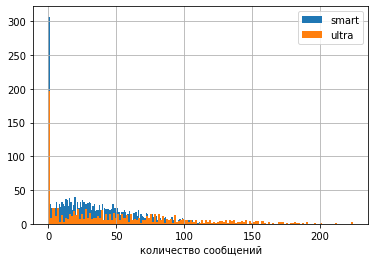

In [36]:
data_smart['count_message_month'].hist(bins=150).set_xlabel('количество сообщений')
data_ultra['count_message_month'].hist(bins=150)
plt.legend(['smart', 'ultra']);

Обычно большинство пользователей ежемесячно укладываются во включенный в тариф лимит сообщений. 
Распределение по количеству сообщений является нормальным скошенным вправо.

Велико количество вариантов, когда не пользуются сообщениями, их заменили мессенджеры. 

 ### Сколько минут

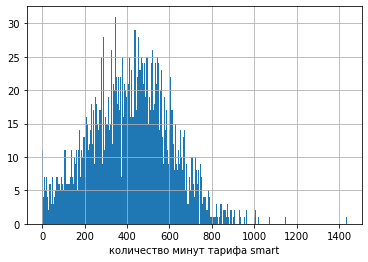

In [37]:
data_smart['sum_duration_minutes'].hist(bins=300).set_xlabel('количество минут тарифа smart');

Здесь видим Нормальное распределение со средним значением 417 минут разговора и медианой 422. 
Мы видим, что чуть меньше половина данных не укладывается в лимит тарифного плана 500 минут разговора.   

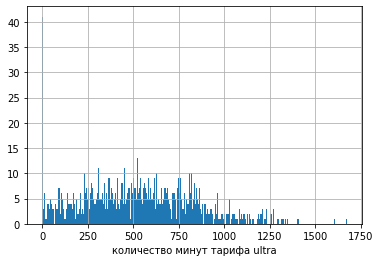

In [38]:
data_ultra['sum_duration_minutes'].hist(bins=300).set_xlabel('количество минут тарифа ultra');

Тариф ultra также имеет нормальное распределение.
Среднее 526 минут. Т.к. в тариф входит 3000 минут, то все клиенты всегда укладываются в лимит тарифа.

### Сколько интернета

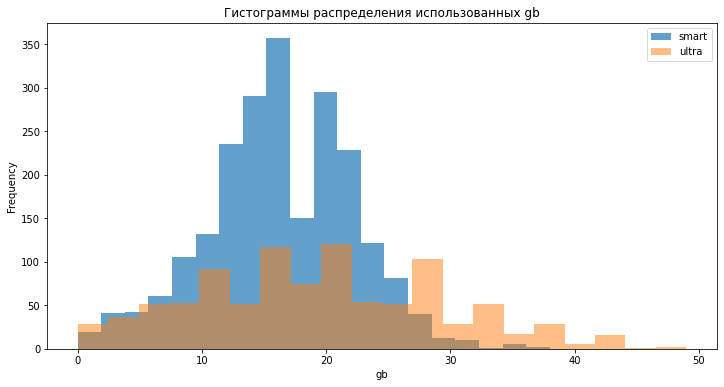

In [39]:
data_smart['gb_used_month'].plot(kind='hist', bins=20, alpha=0.7, figsize=(12,6))
data_ultra['gb_used_month'].plot(kind='hist', bins=20, alpha=0.5, figsize=(12,6))
plt.title('Гистограммы распределения использованных gb')
plt.xlabel('gb')
plt.legend(['smart', 'ultra'])
plt.show()

15 гб и 30 гб включенны в тарифы smart и ultra, соответственно.
Среднее значение требуемого количества интернета 16 и 19 гб, соответственно у тарифов smart и ultra.

Оба распределения нормальные. Тариф smart имеет два пика 15 и 20 гб. В большинстве случаев (более 50 %) клиенты smart выходят за лимит в 15 gb. В тарифе ultra около в 75 % данных клиенты укладываются в предоставляемый лимит 30 гб.

## Проверка гипотез

### Гипотеза равенства средних выручек тарифов

Проверим различается ли средняя выручка пользователей тарифов «Ультра» и «Смарт» с помощью ttest 

scipy.stats.ttest_ind - специальный метод, который используется для проверки гипотезы о равенстве среднего двух генеральных совокупностей

Нулевая гипотеза - средняя выручка пользователей тарифов «Ультра» и «Смарт» равна.

Альтернативая гипотеза - средняя выручка пользователей тарифов «Ультра» и «Смарт» не равна.

In [40]:
array_1 = data_smart['profit']
array_2 = data_ultra['profit']
 
alpha = .05    #критический уровень статистической значимости, возьмем общепринятое пороговые значения — 5%
 
results = st.ttest_ind(array_1, array_2)
 
print('p-значение:', results.pvalue)
 
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу: средняя выручка пользователей тарифов «Ультра» и «Смарт» не равны")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.4229814360764067e-160
Отвергаем нулевую гипотезу: средняя выручка пользователей тарифов «Ультра» и «Смарт» не равны


В гипотезе выдается очень маленькое значение вероятности равенства, поэтому нулевая гипотеза отвергается.

### Гипотеза равенства средней выручки пользователей из Москвы и из других регионов

H₀: средняя выручка пользователей из Москвы равна выручке пользователей из других регионов

H₁: средняя выручка пользователей из Москвы не равна выручке пользователей из других регионов

In [41]:
array_1 = data[data['city'] == 'Москва']['profit']
array_2 = data[data['city'] != 'Москва']['profit']

alpha = .05   #критический уровень статистической значимости
 
results = st.ttest_ind(array_1, array_2)
 
print('p-значение:', results.pvalue)
 
if results.pvalue < alpha:
    print("Отвергаем гипотезу")
else:
    print("Не получилось отвергнуть гипотезу")

p-значение: 0.5440152911670224
Не получилось отвергнуть гипотезу


Вероятность получить равенство средних высоко, поэтому гипотезу не отвергаем.

## Напишите общий вывод

Можно сделать вывод, что тариф smart с позиции оператора более интересен и приносит больше денег за исследуемый период (2,63 млн.), т.к. клиенты чаще переплачивают сверх лимита за звонки и интернет-трафик.

Но лучше развивать и рекламировать сейчас тариф ultra, он более сбалансированный по опциям. С позиции клиента, нет ощущения "обманутости", когда уже заплатил и потом еще нужно доплачивать, как в тарифе smart.

Cреднее значение выручки у ultra больше (2070 руб.), и разрыв между общими выручками по двум тарифам небольшой. Выгоднее привлечь сейчас новых клиентов ultra, и тариф ultra будет приносить больше денег.

### Итоговый вывод 
Перспективным тарифом для оператора является тариф ultra, именно в его пользу нужно скорректировать рекламный бюджет